In [370]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt

%matplotlib inline

dtype_dict = {'bathrooms': float, 'waterfront': int, 'sqft_above': int, 'sqft_living15': float, 'grade': int, 'yr_renovated': int, 'price': float, 'bedrooms': float,
                                                             'zipcode': str, 'long': float, 'sqft_lot15': float, 'sqft_living': float, 'floors': str, 'condition': int, 'lat': float, 'date': str, 'sqft_basement': int, 'yr_built': int, 'id': str, 'sqft_lot': int, 'view': int}

khouse_all_data = pd.read_csv('assessment data/kc_house_data.csv', dtype=dtype_dict)
df_preprocess(khouse_all_data)
khouse_train, khouse_test = train_test_split(khouse_all_data, test_size = 0.2,random_state=3)

evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})


# khouse_train
# khouse_all_data.info()
# khouse_all_data.describe()
# khouse_train.head()

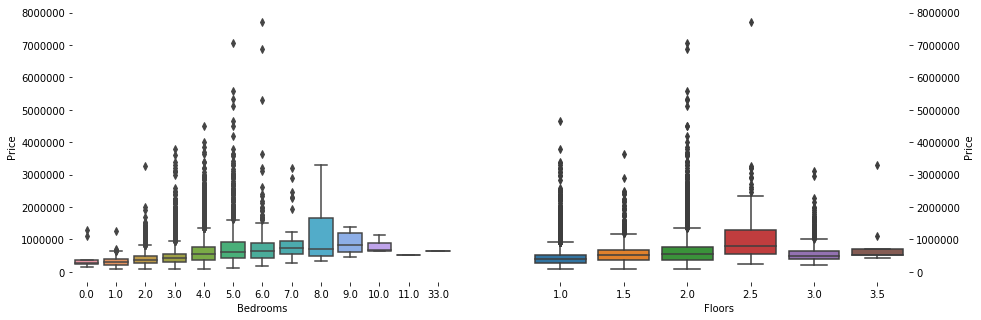

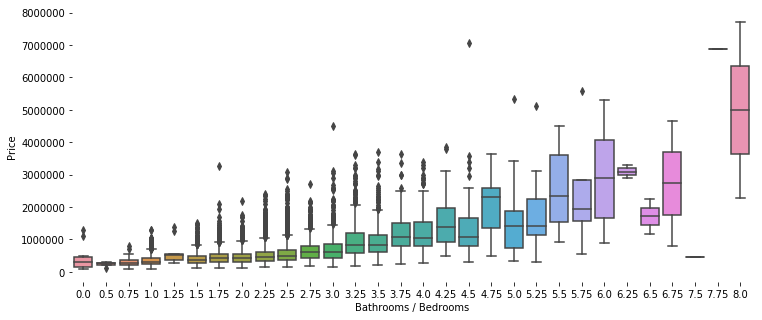

In [371]:
df = khouse_all_data
f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=df['bedrooms'],y=df['price'], ax=axes[0])
sns.boxplot(x=df['floors'],y=df['price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Bedrooms', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Floors', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['bathrooms'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Bathrooms / Bedrooms', ylabel='Price');

In [372]:
all_features = ['bedrooms', 
            'bathrooms',
            'sqft_living', 
            'sqft_lot', 'sqft_lot_sqrt', 'sqft_living_sqrt',
            'floors', 
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above', 'sqft_basement', 'zipcode',
            'yr_built', 'yr_renovated', 'date_byD',
            'lat','long','lat_plus_long',
               'sqft_living15','sqft_lot15']

def df_preprocess(df):
#     df['sqft_living_sqrt'] = df['sqft_living'].apply(sqrt)
#     df['sqft_lot_sqrt'] =df['sqft_lot'].apply(sqrt)
    df['date_byD'] = df['date'].apply(lambda x: (int(x[:4])-2014)*365+int(x[4:6])*12+int(x[6:8]))
    df['floors']=df['floors'].astype('float64')
    df['zipcode']=df['zipcode'].astype('float64')
    add_columns(df)
    

def add_columns(df):
#     df['bedrooms_squared'] = df['bedrooms']**2
#     df['bed_bath_rooms'] = df['bedrooms'] * df['bathrooms']
    df['log_sqft_living'] = np.log(df['sqft_living'])
    df['sqft_living_sqrt'] = df['sqft_living'].apply(np.sqrt)
    df['sqft_lot_sqrt'] = df['sqft_lot'].apply(np.sqrt)
    df['lat_plus_long'] = df['lat']+df['long']
    
df_preprocess(khouse_all_data)

In [382]:
def RSS(y_true, y_pred):
    """ compute residual sum of square. """
    return ((y_true-y_pred)**2).sum()


def R2(y_true, y_pred):
    """ compute None-weighted r2. """
    numerator = ((y_true - y_pred) ** 2).sum()
    denominator = ((y_true - np.average(y_true, axis=0)) ** 2).sum()
    return float(format(1-numerator/denominator, '.3f'))


def RMSE(y_true, y_pred):
    """ Compute root mean square errors. """
    return float(format(np.sqrt(((y_true-y_pred)**2).sum()/len(y_true)), '.3f'))


def cross_validation_5folded(model, df, target):
    """ Compute 5_fold cross validation score. """
    return float(format(cross_val_score(model, df, target, cv=5).mean(), '.3f'))


def adjustedR2(r2, n, p):
    """ Adjust R2, avoid R2 increase when number of features increase. """
    if n <= p+1:
        p = n-2
    return float(format(1-(n-1)/(n-p-1)*(1-r2), '.3f'))


def fill_evaluation(model_name, model_detail, train_y_true, train_y_pred, y_true, y_pred, n, k, model, df, target):
    ''' Fill the evaluation of the model in evaluation dataframe. '''
    rmse = RMSE(y_true, y_pred)
    r2_train = R2(train_y_true, train_y_pred)
    r2_test = R2(y_true, y_pred)

    ad_R2_train = adjustedR2(r2_train, n, k)
    ad_R2_test = adjustedR2(r2_test, n, k)

    cv = cross_validation_5folded(model, df, target)

    r = evaluation.shape[0]
    evaluation.loc[r] = [model_name,
                         model_detail, rmse, r2_train, ad_R2_train, r2_test, ad_R2_test, cv]
    evaluation.sort_values(by='5-Fold Cross Validation',
                           ascending=False, inplace=True)

In [374]:
from sklearn.linear_model import LinearRegression
lm_1 = LinearRegression()
lm_2 = LinearRegression()
lm_3 = LinearRegression()
lm_lasso3, lm_lasso5, lm_lasso7 = LinearRegression(), LinearRegression(), LinearRegression()

number_all_features = len(all_features)
intuitive_5features = ['sqft_living', 'bedrooms', 'bathrooms', 'lat', 'long']
simple_feature = ['sqft_living']
lasso_3features = ['sqft_living', 'grade', 'lat']
lasso_5features = ['sqft_living', 'waterfront', 'view', 'grade', 'yr_built', 'lat']
lasso_7features = ['sqft_living', 'waterfront', 'view', 'grade', 'yr_built', 'lat', 'sqft_living15']
lasso_11features = ['bathrooms', 'sqft_living', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15']

df_1 = khouse_train[intuitive_5features]
df_2 = khouse_train[all_features]
df_3 = khouse_train[simple_feature]
df_lasso3 = khouse_train[lasso_3features]
df_lasso5 = khouse_train[lasso_5features]
df_lasso7 = khouse_train[lasso_7features]

lm_1.fit(df_1, khouse_train['price'])
lm_2.fit(df_2, khouse_train['price'])
lm_3.fit(df_3, khouse_train['price'])
lm_lasso3.fit(df_lasso3, khouse_train['price'])
lm_lasso5.fit(df_lasso5, khouse_train['price'])
lm_lasso7.fit(df_lasso7, khouse_train['price'])

tf_1 = khouse_test[intuitive_5features]
tf_2 = khouse_test[all_features]
tf_3 = khouse_test[simple_feature]
tf_lasso3 = khouse_test[lasso_3features]
tf_lasso5 = khouse_test[lasso_5features]
tf_lasso7 = khouse_test[lasso_7features]



train_y_true = khouse_train['price']
y_true = khouse_test['price']
fill_evaluation('Simple linear regression', 'only sqft_living', train_y_true, lm_3.predict(df_3), y_true, 
                lm_3.predict(tf_3), number_all_features, 1, lm_3, khouse_all_data[simple_feature],khouse_all_data['price'])
fill_evaluation('Multiple linear regression', '5 intuitive features', train_y_true, lm_1.predict(df_1), y_true, 
                lm_1.predict(tf_1), number_all_features, 5, lm_1, khouse_all_data[intuitive_5features],khouse_all_data['price'])
fill_evaluation('Multiple linear regression', 'all 22 features', train_y_true, lm_2.predict(df_2), y_true, 
                lm_2.predict(tf_2), number_all_features, len(all_features), lm_2, khouse_all_data[all_features],khouse_all_data['price'])
fill_evaluation('Multiple linear regression', 'Lasso selected 3 features', train_y_true, lm_lasso3.predict(df_lasso3), y_true, 
                lm_lasso3.predict(tf_lasso3), number_all_features, 3, lm_lasso3, khouse_all_data[lasso_3features],khouse_all_data['price'])
fill_evaluation('Multiple linear regression', 'Lasso selected 5 features', train_y_true, lm_lasso5.predict(df_lasso5), y_true, 
                lm_lasso5.predict(tf_lasso5), number_all_features, 5, lm_lasso5, khouse_all_data[lasso_5features],khouse_all_data['price'])
fill_evaluation('Multiple linear regression', 'Lasso selected 7 features', train_y_true, lm_lasso7.predict(df_lasso7), y_true, 
                lm_lasso7.predict(tf_lasso7), number_all_features, 7, lm_lasso7, khouse_all_data[lasso_7features],khouse_all_data['price'])

evaluation

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple linear regression,only sqft_living,254289.149,0.492,0.467,0.496,0.471,0.491
1,Multiple linear regression,5 intuitive features,228094.478,0.589,0.461,0.595,0.468,0.589
2,Multiple linear regression,all 22 features,183718.592,0.731,-4.649,0.737,-4.523,0.727
3,Multiple linear regression,Lasso selected 3 features,226162.576,0.595,0.527,0.602,0.536,0.595
4,Multiple linear regression,Lasso selected 5 features,199176.733,0.682,0.583,0.691,0.594,0.680
5,Multiple linear regression,Lasso selected 7 features,199164.215,0.683,0.525,0.691,0.536,0.679


### Polynomial Regression:

In [375]:
def polynomial_dataframe(df, features, degree):
    ''' Make a new dataframe of degree-polynomial for features. '''
    poly_dataframe = pd.DataFrame()
    for feature in features:
        poly_dataframe[feature+'_power_1'] = df[feature]
        if degree > 1:
            for power in range(2, degree+1):
                name = feature+'power_' + str(power)
                poly_dataframe[name]=df[feature]**power
    return poly_dataframe


features = lasso_5features
# for features in [lasso_3features, lasso_5features, lasso_7features]:
#     print('\n', features)
for degree in range(1,10):
    poly = polynomial_dataframe(khouse_train, features, degree)
    score = cross_validate(LinearRegression(), poly, khouse_train['price'], cv=4, return_train_score=False)
    score = sum(score['test_score'])/4
    print('Validation R2 of poly-', degree,'is:',score)

Validation R2 of poly- 1 is: 0.6810530026185805
Validation R2 of poly- 2 is: 0.7185643173460152
Validation R2 of poly- 3 is: 0.7009680692657636
Validation R2 of poly- 4 is: 0.6954573871336209
Validation R2 of poly- 5 is: 0.6623774928030106
Validation R2 of poly- 6 is: 0.6268790805169412
Validation R2 of poly- 7 is: 0.36006042483538014
Validation R2 of poly- 8 is: -2.7216568498576157
Validation R2 of poly- 9 is: -20.913656862788365


In [243]:
## implementing k_fold cross validation
# n = len(shuffle_train_data)
# output = shuffle_train_data['price']
# for degree in range(1,10):
#     cur_sum = 0
#     for j in range(k):
#         start = int((n*j)/k)
#         end = int((n*(j+1))/k-1)
#         k_fold_cv_train = shuffle_train_data[0:start].append(shuffle_train_data[end+1:n])
#         k_fold_cv_valid = shuffle_train_data[start:end+1]
#         y_train = output[0:start].append(output[end+1:n])
#         y_valid = output[start:end+1]
#         poly = polynomial_dataframe(k_fold_cv_train, features, degree)
#         poly_v = polynomial_dataframe(k_fold_cv_valid, features, degree)
#         model = LinearRegression()
#         model.fit(poly, khouse_train['price'])
#         cur_sum += RSS(k_fold_cv_valid['price'],model.predict(poly_v))
#     print('RSS of poly-',i,' is: ',cur_sum)

In [376]:
poly = polynomial_dataframe(khouse_train, lasso_7features, 2)
poly_test = polynomial_dataframe(khouse_test, lasso_7features, 2)
poly_all = polynomial_dataframe(khouse_all_data, lasso_7features, 2)
model = LinearRegression()
model.fit(poly, khouse_train['price'])
fill_evaluation('Polynomial regression', 'Degree-2, Lasso selected 7 features.', train_y_true, model.predict(poly), y_true, 
                model.predict(poly_test), number_all_features, 7, model, poly_all, khouse_all_data['price'])

poly = polynomial_dataframe(khouse_train, lasso_5features, 2)
poly_test = polynomial_dataframe(khouse_test, lasso_5features, 2)
poly_all = polynomial_dataframe(khouse_all_data, lasso_5features, 2)
model = LinearRegression()
model.fit(poly, khouse_train['price'])
fill_evaluation('Polynomial regression', 'Degree-2, Lasso selected 5 features.', train_y_true, model.predict(poly), y_true, 
                model.predict(poly_test), number_all_features, 5, model, poly_all, khouse_all_data['price'])


poly = polynomial_dataframe(khouse_train, all_features, 2)
poly_test = polynomial_dataframe(khouse_test, all_features, 2)
poly_all = polynomial_dataframe(khouse_all_data, all_features, 2)
model = LinearRegression()
model.fit(poly, khouse_train['price'])
fill_evaluation('Polynomial regression', 'Degree-2, all features.', train_y_true, model.predict(poly), y_true, 
                model.predict(poly_test), number_all_features, len(all_features), model, poly_all, khouse_all_data['price'])

evaluation

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple linear regression,only sqft_living,254289.149,0.492,0.467,0.496,0.471,0.491
1,Multiple linear regression,5 intuitive features,228094.478,0.589,0.461,0.595,0.468,0.589
2,Multiple linear regression,all 22 features,183718.592,0.731,-4.649,0.737,-4.523,0.727
3,Multiple linear regression,Lasso selected 3 features,226162.576,0.595,0.527,0.602,0.536,0.595
4,Multiple linear regression,Lasso selected 5 features,199176.733,0.682,0.583,0.691,0.594,0.680
5,Multiple linear regression,Lasso selected 7 features,199164.215,0.683,0.525,0.691,0.536,0.679
6,Polynomial regression,"Degree-2, Lasso selected 7 features.",184146.368,0.731,0.597,0.736,0.604,0.721
7,Polynomial regression,"Degree-2, Lasso selected 5 features.",184339.696,0.729,0.644,0.735,0.652,0.721
8,Polynomial regression,"Degree-2, all features.",170642.927,0.763,-3.977,0.773,-3.767,0.741


### Ridge Regression:

In [377]:
### find paremteor for polynomial ridge regresssion by cross validation

features = lasso_5features
vd_df = pd.DataFrame()
vd_df['idx'] = ['poly-'+str(d) for d in range(1,11)]
tmp = []
for degree in range(1,11):
    poly = polynomial_dataframe(khouse_train, features, degree)
    score = cross_validate(LinearRegression(), poly, khouse_train['price'], cv=4, return_train_score=False)
    score = sum(score['test_score'])/4
    tmp.append(score)
vd_df['0 penalty'] = tmp

for penalty in [1e-12,1e-11,1e-9,1e-5,  1]:
    tmp = []
    for degree in range(1,11):
        poly = polynomial_dataframe(khouse_train, features, degree)
        score = cross_validate(Ridge(alpha=penalty, normalize = True), poly, khouse_train['price'], cv=4, return_train_score=False)
        score = sum(score['test_score'])/4
        tmp.append(score)
    vd_df[penalty] = tmp
print(vd_df)


       idx   0 penalty     1e-12     1e-11     1e-09     1e-05         1
0   poly-1    0.681053  0.681053  0.681053  0.681053  0.681053  0.581921
1   poly-2    0.718564  0.718564  0.718564  0.718564  0.713025  0.665142
2   poly-3    0.700968  0.722176  0.707191  0.700793  0.696909  0.684620
3   poly-4    0.695457  0.724444  0.717841  0.699175  0.694873  0.680072
4   poly-5    0.662377  0.731088  0.729452  0.705936  0.702432  0.673544
5   poly-6    0.626879  0.747114  0.746201  0.719486  0.723840  0.669030
6   poly-7    0.360060 -0.138164 -0.140537 -0.136096  0.740742  0.666319
7   poly-8   -2.721657 -1.682922 -1.656327 -1.143259  0.657507  0.664721
8   poly-9  -20.913657 -2.388491 -2.307011 -2.077357  0.324699  0.663943
9  poly-10 -109.969663 -6.757961 -3.395918 -2.492876 -0.418659  0.663940


In [378]:
### find paremteor for polynomial ridge regresssion by cross validation

features = lasso_11features
vd_df = pd.DataFrame()
vd_df['idx'] = ['poly-'+str(d) for d in range(1,11)]
tmp = []
for degree in range(1,11):
    poly = polynomial_dataframe(khouse_train, features, degree)
    score = cross_validate(LinearRegression(), poly, khouse_train['price'], cv=4, return_train_score=False)
    score = sum(score['test_score'])/4
    tmp.append(score)
vd_df['0_penalty'] = tmp

for penalty in [1e-12,1e-9, 1e-7,1e-5, 1]:
    tmp = []
    for degree in range(1,11):
        poly = polynomial_dataframe(khouse_train, features, degree)
        score = cross_validate(Ridge(alpha=penalty, normalize = True), poly, khouse_train['price'], cv=4, return_train_score=False)
        score = sum(score['test_score'])/4
        tmp.append(score)
    vd_df[penalty] = tmp
print(vd_df)

       idx  0_penalty      1e-12     1e-09     1e-07     1e-05         1
0   poly-1   0.686273   0.686273  0.686273  0.686273  0.686273  0.614018
1   poly-2   0.731350   0.731350  0.731350  0.731296  0.725254  0.684904
2   poly-3   0.715455   0.737370  0.715139  0.714256  0.710546  0.702130
3   poly-4   0.691384   0.737286  0.708959  0.707466  0.705788  0.697799
4   poly-5   0.670677   0.755576  0.731495  0.729824  0.718371  0.692485
5   poly-6   0.649270   0.742655  0.712245  0.723151  0.745909  0.689792
6   poly-7   0.507633  -0.111782 -0.118995  0.520718  0.745352  0.688334
7   poly-8  -1.057713  -2.686370 -1.431356 -0.172747  0.637242  0.687452
8   poly-9 -18.026591  -4.560029 -3.493728 -1.471725  0.297157  0.686878
9  poly-10 -63.820625 -11.003485 -5.049564 -3.244483 -0.442392  0.687027


In [379]:
poly = polynomial_dataframe(khouse_train, lasso_5features, 6)
poly_test = polynomial_dataframe(khouse_test, lasso_5features, 6)
poly_all = polynomial_dataframe(khouse_all_data, lasso_5features, 6)
model = Ridge(alpha = 1e-12, normalize = True)
model.fit(poly, khouse_train['price'])
fill_evaluation('Ridge polynomial regression', 'Degree-6, alpha:1e-12, Lasso selected 5 features.', train_y_true, model.predict(poly), y_true, 
                model.predict(poly_test), number_all_features, 5, model, poly_all, khouse_all_data['price'])

poly = polynomial_dataframe(khouse_train, lasso_11features, 5)
poly_test = polynomial_dataframe(khouse_test, lasso_11features, 5)
poly_all = polynomial_dataframe(khouse_all_data, lasso_11features, 5)
model = Ridge(alpha = 1e-12, normalize = True)
model.fit(poly, khouse_train['price'])
fill_evaluation('Ridge polynomial regression', 'Degree-5, alpha:1e-12, Lasso selected 11 features.', train_y_true, model.predict(poly), y_true, 
                model.predict(poly_test), number_all_features, 11, model, poly_all, khouse_all_data['price'])

evaluation

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple linear regression,only sqft_living,254289.149,0.492,0.467,0.496,0.471,0.491
1,Multiple linear regression,5 intuitive features,228094.478,0.589,0.461,0.595,0.468,0.589
2,Multiple linear regression,all 22 features,183718.592,0.731,-4.649,0.737,-4.523,0.727
3,Multiple linear regression,Lasso selected 3 features,226162.576,0.595,0.527,0.602,0.536,0.595
4,Multiple linear regression,Lasso selected 5 features,199176.733,0.682,0.583,0.691,0.594,0.680
5,Multiple linear regression,Lasso selected 7 features,199164.215,0.683,0.525,0.691,0.536,0.679
6,Polynomial regression,"Degree-2, Lasso selected 7 features.",184146.368,0.731,0.597,0.736,0.604,0.721
7,Polynomial regression,"Degree-2, Lasso selected 5 features.",184339.696,0.729,0.644,0.735,0.652,0.721
8,Polynomial regression,"Degree-2, all features.",170642.927,0.763,-3.977,0.773,-3.767,0.741
9,Ridge polynomial regression,"Degree-6, alpha:1e-12, Lasso selected 5 features.",173646.136,0.773,0.702,0.765,0.692,0.764


### Lasso Regression:

In [380]:
""" Features selection by lasso. """
for penalty in [1e2, 1.5e2, 3e2, 4e2, 6e2, 6.8e2, 7e2, 1.5e3]:
    model = Lasso(alpha=penalty, normalize=True)
    model.fit(khouse_all_data[all_features], khouse_all_data['price']) # learn weights
    print([all_features[i] for i in range(len(model.coef_)) if model.coef_[i] ])

['bathrooms', 'sqft_living', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15']
['sqft_living', 'waterfront', 'view', 'grade', 'yr_built', 'lat', 'sqft_living15']
['sqft_living', 'waterfront', 'view', 'grade', 'yr_built', 'lat']
['sqft_living', 'waterfront', 'view', 'grade', 'lat']
['sqft_living', 'view', 'grade', 'lat']
['sqft_living', 'grade', 'lat']
['sqft_living', 'grade']
['sqft_living']


In [341]:
### find paremteor for polynomial ridge regresssion by cross validation

features = all_features

for penalty in [1e1,5e1, 1e2, 1e3]:
    df = khouse_train[all_features]
    score = cross_validate(Lasso(alpha=penalty, normalize=True), df, khouse_train['price'], 
                           cv=4, return_train_score=False)
    score = sum(score['test_score'])/4
    print('penalty:',penalty,' validation score:',score)
    
# 在這組Data中，即使20個features全選，也沒有造成明顯overfit(test error上升)，
# 所以Ridge regression有penalty越小score越高的現象

penalty: 10.0  validation score: 0.7253728446473986
penalty: 50.0  validation score: 0.6925235888791377
penalty: 100.0  validation score: 0.6802856521733776
penalty: 1000.0  validation score: 0.4242654970584012


In [350]:
### find paremteor for polynomial ridge regresssion by cross validation

features = all_features
vd_df = pd.DataFrame()
vd_df['idx'] = ['poly-'+str(d) for d in range(1,8)]
tmp = []
for degree in range(1,8):
    poly = polynomial_dataframe(khouse_train, features, degree)
    score = cross_validate(LinearRegression(), poly, khouse_train['price'], cv=4, return_train_score=False)
    score = sum(score['test_score'])/4
    tmp.append(score)
vd_df['0_penalty'] = tmp

for penalty in [8e1, 1e2, 1.5e2, 3e2]:
    tmp = []
    for degree in range(1,8):
        poly = polynomial_dataframe(khouse_train, features, degree)
        score = cross_validate(Lasso(alpha=penalty, normalize=True), poly, 
                               khouse_train['price'], cv=4, return_train_score=False)
        score = sum(score['test_score'])/4
        tmp.append(score)
    # record number of features left
    vd_df[penalty] = tmp
print(vd_df)

      idx  0_penalty      80.0     100.0     150.0     300.0
0  poly-1   0.727219  0.685810  0.680286  0.671445  0.640551
1  poly-2   0.744514  0.720439  0.716269  0.707857  0.673106
2  poly-3   0.364746  0.711712  0.708120  0.701175  0.669366
3  poly-4   0.520458  0.709853  0.707858  0.701983  0.670576
4  poly-5   0.524834  0.708608  0.706879  0.701699  0.668768
5  poly-6  -0.141359  0.708209  0.706732  0.701706  0.668768
6  poly-7  -1.219209  0.708208  0.706624  0.701723  0.668768


In [381]:
features = all_features
poly = polynomial_dataframe(khouse_train, features, 2)
poly_test = polynomial_dataframe(khouse_test, features, 2)
poly_all = polynomial_dataframe(khouse_all_data, features, 2)
model = Lasso(alpha = 8e1, normalize = True)
model.fit(poly, khouse_train['price'])
fill_evaluation('Lasso polynomial regression', 'Degree-2, alpha: 8e1, all features.', train_y_true, model.predict(poly), y_true, 
                model.predict(poly_test), number_all_features, len(all_features), model, poly_all, khouse_all_data['price'])


features = lasso_5features
poly = polynomial_dataframe(khouse_train, features, 2)
poly_test = polynomial_dataframe(khouse_test, features, 2)
poly_all = polynomial_dataframe(khouse_all_data, features, 2)
model = Lasso(alpha = 8e1, normalize = True)
model.fit(poly, khouse_train['price'])
fill_evaluation('Lasso polynomial regression', 'Degree-2, alpha: 8e1, Lasso selected 5 features.', train_y_true, model.predict(poly), y_true, 
                model.predict(poly_test), number_all_features, 5, model, poly_all, khouse_all_data['price'])

features = all_features
df_train = khouse_train[features]
df_test = khouse_test[features]
model = Lasso(alpha=penalty, normalize=True)
model.fit(df_train, khouse_train['price'])
fill_evaluation('Lasso regression', 'alpha: 8e1, all features.', train_y_true, model.predict(df_train), y_true, 
                model.predict(df_test), number_all_features, len(features), model, khouse_all_data[features], khouse_all_data['price'])

evaluation

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple linear regression,only sqft_living,254289.149,0.492,0.467,0.496,0.471,0.491
1,Multiple linear regression,5 intuitive features,228094.478,0.589,0.461,0.595,0.468,0.589
2,Multiple linear regression,all 22 features,183718.592,0.731,-4.649,0.737,-4.523,0.727
3,Multiple linear regression,Lasso selected 3 features,226162.576,0.595,0.527,0.602,0.536,0.595
4,Multiple linear regression,Lasso selected 5 features,199176.733,0.682,0.583,0.691,0.594,0.680
5,Multiple linear regression,Lasso selected 7 features,199164.215,0.683,0.525,0.691,0.536,0.679
6,Polynomial regression,"Degree-2, Lasso selected 7 features.",184146.368,0.731,0.597,0.736,0.604,0.721
7,Polynomial regression,"Degree-2, Lasso selected 5 features.",184339.696,0.729,0.644,0.735,0.652,0.721
8,Polynomial regression,"Degree-2, all features.",170642.927,0.763,-3.977,0.773,-3.767,0.741
9,Ridge polynomial regression,"Degree-6, alpha:1e-12, Lasso selected 5 features.",173646.136,0.773,0.702,0.765,0.692,0.764


### KNN:

In [363]:
### cross validation to find K

features = lasso_5features
for k in [10, 15,17,19 ,20,21]:
    df = khouse_train[features]
    score = cross_validate(KNeighborsRegressor(n_neighbors=k), df, khouse_train['price'], 
                           cv=4, return_train_score=False)
    score = sum(score['test_score'])/4
    print('k:',k,' validation score:',score)
print()

features = all_features
for k in [5,8,10, 15,17,19]:
    df = khouse_train[features]
    score = cross_validate(KNeighborsRegressor(n_neighbors=k), df, khouse_train['price'], 
                           cv=4, return_train_score=False)
    score = sum(score['test_score'])/4
    print('k:',k,' validation score:',score)

k: 10  validation score: 0.5435704838436379
k: 15  validation score: 0.5505031883969888
k: 17  validation score: 0.5518801478300513
k: 19  validation score: 0.5533019329669399
k: 20  validation score: 0.5522086905585952
k: 21  validation score: 0.5507602978402312

k: 5  validation score: 0.4842196105356309
k: 8  validation score: 0.4943249642577426
k: 10  validation score: 0.4958147988283191
k: 15  validation score: 0.49101814881483585
k: 17  validation score: 0.4899470603216759
k: 19  validation score: 0.4872869543151488


In [383]:
features = lasso_5features
df_train = khouse_train[features]
df_test = khouse_test[features]
model = KNeighborsRegressor(n_neighbors=19)
model.fit(df_train, khouse_train['price'])
fill_evaluation('KNN regression', 'K: 19, Lasso selected 5 features.', train_y_true, model.predict(df_train), y_true, 
                model.predict(df_test), number_all_features, 5, model, khouse_all_data[features], khouse_all_data['price'])


features = lasso_5features
df_train = khouse_train[features]
df_test = khouse_test[features]
model = KNeighborsRegressor(n_neighbors=9)
model.fit(df_train, khouse_train['price'])
fill_evaluation('KNN regression', 'K: 9, Lasso selected 5 features.', train_y_true, model.predict(df_train), y_true, 
                model.predict(df_test), number_all_features, 5, model, khouse_all_data[features], khouse_all_data['price'])


features = lasso_11features
df_train = khouse_train[features]
df_test = khouse_test[features]
model = KNeighborsRegressor(n_neighbors=19)
model.fit(df_train, khouse_train['price'])
fill_evaluation('KNN regression', 'K: 19, Lasso selected 11 features.', train_y_true, model.predict(df_train), y_true, 
                model.predict(df_test), number_all_features, 11, model, khouse_all_data[features], khouse_all_data['price'])

evaluation

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
9,Ridge polynomial regression,"Degree-6, alpha:1e-12, Lasso selected 5 features.",173646.136,0.773,0.702,0.765,0.692,0.764
8,Polynomial regression,"Degree-2, all features.",170642.927,0.763,-3.977,0.773,-3.767,0.741
2,Multiple linear regression,all 22 features,183718.592,0.731,-4.649,0.737,-4.523,0.727
6,Polynomial regression,"Degree-2, Lasso selected 7 features.",184146.368,0.731,0.597,0.736,0.604,0.721
7,Polynomial regression,"Degree-2, Lasso selected 5 features.",184339.696,0.729,0.644,0.735,0.652,0.721
11,Lasso polynomial regression,"Degree-2, alpha: 8e1, all features.",185276.347,0.724,-4.796,0.733,-4.607,0.718
12,Lasso polynomial regression,"Degree-2, alpha: 8e1, Lasso selected 5 features.",188251.680,0.715,0.626,0.724,0.638,0.710
10,Ridge polynomial regression,"Degree-5, alpha:1e-12, Lasso selected 11 featu...",167507.503,0.783,0.544,0.781,0.540,0.702
4,Multiple linear regression,Lasso selected 5 features,199176.733,0.682,0.583,0.691,0.594,0.680
5,Multiple linear regression,Lasso selected 7 features,199164.215,0.683,0.525,0.691,0.536,0.679
